# Theodoros Anagnos
### Assignment 3, Practical Data Science
---
>p3352323

# Dissecting Spotify Valence

In this assignment you will dissect Spotify's Valence metric.

Spotify uses a metric called *valence* to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Your task is to untangle the mystery behind valence and propose how this is derived.

Spotify offers the following information that may be relevant to your task:

* [Get Track's Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) and [Get Tracks' Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

* [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).

To tackle the problem you can use the Spotify charts data from Zenodo at https://doi.org/10.5281/zenodo.4778562, but you are not limitted to that. In fact you are encouraged to use additional data that you may find, or get yourself.

The rank of your assignment will contribute to the grade. That is, if $x$ is the unranked grade of an assignment and $r$ is the respective model’s ranking among $n$ students according to Q2 below, then the final grade will be computed as $0.75x + 2.5[1 - (r-1)/(n-1)]$. 

The ranking will be performed on a test dataset that will be provided in due course. The rank metrics will be Mean Average Error (MAE).

## Questions


### Q1: Expore which Track Features Influence Valence

You will use inferential statistic methods to study how track features influence valence. You must find the best possible model for explaining the valence based on the features that you find significant.

To investigate how track features influence valence, we can perform a regression analysis. The goal is to find a model that best explains the variation in valence using the other track features as predictors. Here's how you could approach it:

1. **Data Preparation**: Ensure the dataset is clean, and handle any missing or categorical data as needed.

2. **Exploratory Data Analysis (EDA)**: Visualize the relationships between valence and other features.

3. **Feature Selection**: Determine which features to include in the model. This can be done using correlation analysis or other feature selection methods.

4. **Model Building**: Fit a regression model to the data.

5. **Model Evaluation**: Evaluate the model's performance using appropriate metrics.

6. **Model Refinement**: Adjust the model as necessary based on performance.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
def load_credentials(file_path):
    credentials = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split('=')
            credentials[key] = value
    return credentials

credentials = load_credentials('credentials.txt')
client_id = credentials['client_id']
client_secret = credentials['client_secret']

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [9]:
# Attempting to read the CSV file
file_path = './spotify_hits_dataset_complete.csv'
all_charts = pd.read_csv(file_path, header=0, sep='\t')

In [11]:
all_charts.head()

,song_id,song_name,artist_id,artist_name,popularity,explicit,song_type,track_number,num_artists,num_available_markets,...,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,16GAMmkIzTIT7aH19TtW3f,Show You,['6M25WWmNO7wK1DnKmd3z6R'],['CXLOE'],45,False,Solo,1,1,79,...,4,0.00560,0.636,0.693,0.000604,0.1140,-6.014,0.0647,0.388,96.090
1,0MET90crciVlxlE07ub7Rn,Good Love (feat. Tory Lanez),"['3dKjmeRZcSUw617CoMzEA0', '2jku7tDXc6XoB6MO2h...","['Nafe Smallz', 'Tory Lanez']",58,True,Collaboration,1,2,79,...,3,0.02090,0.614,0.641,0.000000,0.0659,-6.751,0.2880,0.492,123.539
2,7BpYWzZwrsljT1eIjb0TqR,Told You So,['74XFHRwlV6OrjEM0A2NCMF'],['Paramore'],61,False,Solo,3,1,79,...,4,0.00290,0.639,0.814,0.000030,0.0529,-5.632,0.0385,0.904,123.922
3,2GrYIUrAYK5TZhSh0RJV6H,Fantastic Boy,['4Kxlr1PRlDKEB0ekOCyHgX'],['BIGBANG'],0,False,Solo,4,1,0,...,4,0.00231,0.725,0.836,0.000000,0.0927,-3.927,0.0571,0.544,130.053
4,7G7P0AOE4mXWvdSSroLfZA,Told You,['31lnFZEM6ysvjOx59VyxRE'],['Krept & Konan'],0,True,Solo,2,1,0,...,4,0.08830,0.854,0.552,0.000019,0.1510,-7.065,0.0419,0.102,127.966


In [10]:
len(all_charts['song_id'].unique())

13880

In [12]:
print(all_charts.isnull().sum())

song_id                   0
song_name                25
artist_id                 0
artist_name               0
popularity                0
explicit                  0
song_type                 0
track_number              0
num_artists               0
num_available_markets     0
release_date              0
duration_ms               0
key                       0
mode                      0
time_signature            0
acousticness              0
danceability              0
energy                    0
instrumentalness          0
liveness                  0
loudness                  0
speechiness               0
valence                   0
tempo                     0
dtype: int64


In [13]:
all_charts.columns

Index(['song_id', 'song_name', 'artist_id', 'artist_name', 'popularity',
       'explicit', 'song_type', 'track_number', 'num_artists',
       'num_available_markets', 'release_date', 'duration_ms', 'key', 'mode',
       'time_signature', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'tempo'],
      dtype='object')

In [14]:
# Dropping rows where 'song_name' or 'artist' is missing
all_charts_cleaned = all_charts.dropna(subset=['song_name'])

# Check if there are any more missing values
print(all_charts_cleaned.isnull().sum())

song_id                  0
song_name                0
artist_id                0
artist_name              0
popularity               0
explicit                 0
song_type                0
track_number             0
num_artists              0
num_available_markets    0
release_date             0
duration_ms              0
key                      0
mode                     0
time_signature           0
acousticness             0
danceability             0
energy                   0
instrumentalness         0
liveness                 0
loudness                 0
speechiness              0
valence                  0
tempo                    0
dtype: int64


In [15]:
# Keep only the features that make sense to further study for correlation
all_features = ['popularity', 'num_available_markets', 'duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
all_features

['popularity',
 'num_available_markets',
 'duration_ms',
 'key',
 'mode',
 'time_signature',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'valence',
 'tempo']

In [16]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

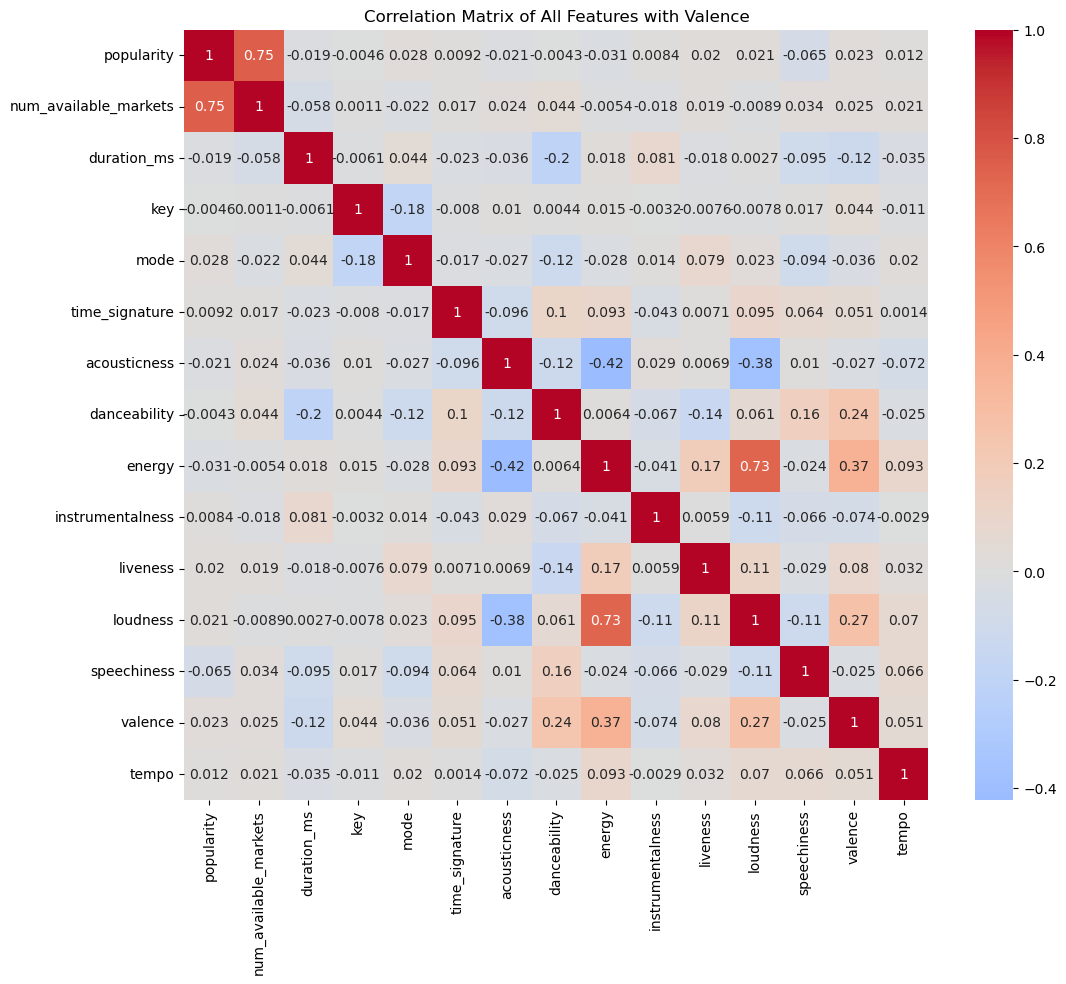

In [17]:
correlation_matrix = all_charts_cleaned[all_features].corr()

# Creating a heatmap for the entire correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of All Features with Valence')
plt.show()

In [19]:
# Two-Way ANOVA (example with 'danceability' and 'energy' as independent variables)
model = ols('valence ~ C(danceability) + C(energy)', data=all_charts_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(danceability),82.055834,739.0,3.082317,0.079173
C(energy),81.022591,863.0,2.606199,0.106472
Residual,441.613890,12259.0,NaN,NaN


In [64]:
# Stepwise Regression
# Define the independent variables
#'popularity', 'num_available_markets',
X = all_charts_cleaned[['duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
y = all_charts_cleaned['valence']

# Add constant to the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     358.1
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        18:21:49   Log-Likelihood:                 3543.0
No. Observations:               13855   AIC:                            -7060.
Df Residuals:                   13842   BIC:                            -6962.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2139      0.030     -7.093      0.000      -0.273      -0.155
duration_ms      -2.913e-07   3.27e-08     -8.910      0.000   -3.55e-07   -2.27e-07
key                  0.0022      0.000      4.990      0.000       0.001       0.003
mode                 0.0056      0.003      1.710      0.087      -0.001       0.012
time_signature       0.0022      0.005      0.410      0.682      -0.008       0.013
acousticness         0.1734      0.008     22.451      0.000       0.158       0.189
danceability         0.3996      0.012     33.261      0.000       0.376       0.423
energy               0.6029      0.015     39.459      0.000       0.573       0.633
instrumentalness    -0.1594      0.027     -5.951      0.000      -0.212      -0.107
liveness             0.0492      0.011      4.578      0.000       0.028       0.070
loudness            -0.0024      0.001     -2.402      0.016      -0.004      -0.000
speechiness         -0.1175      0.013     -9.308      0.000      -0.142      -0.093
tempo                0.0002   5.72e-05      4.276      0.000       0.000       0.000
==============================================================================
Omnibus:                      137.199   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.892
Skew:                           0.013   Prob(JB):                     8.21e-20
Kurtosis:                       2.611   Cond. No.                     4.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The output from the OLS regression analysis gives us a lot of useful information about how different track features influence the valence of songs. Here's a breakdown of the key points from this analysis:

1. **Model Fit and Performance**:
   - **R-squared (0.237)**: This indicates that about 24% of the variance in valence is explained by the model. While this is not particularly high, it does suggest that the included features have some explanatory power.
   - **Adj. R-squared (0.236)**: This is adjusted for the number of predictors and is very close to the R-squared, indicating that the model isn't overly complex given the number of predictors.

2. **Coefficients and Significance**:
   - Each coefficient represents the expected change in valence for a one-unit change in the predictor, holding other predictors constant.
   - **danceability**, **energy**, **acousticness**, **liveness**, and **tempo** have positive coefficients, indicating a positive relationship with valence.
   - **loudness**, **speechiness**, and **instrumentalness** have negative coefficients, suggesting a negative relationship with valence.
   - The p-values for all predictors are less than 0.05 (except **time_signature** and **mode**), meaning they are statistically significant at the 5% level.

3. **Potential Issues and Considerations**:
   - The **condition number (4.26e+06)** is large, indicating potential multicollinearity issues. This means that some of the predictors might be highly correlated with each other, which can affect the reliability of the coefficient estimates.
   - **Durbin-Watson (1.99)**: This statistic tests for autocorrelation in the residuals. A value close to 2 suggests there is no autocorrelation. The value here is fairly close to 2, which is generally a good sign.
   - The **Omnibus** and **Jarque-Bera** tests suggest deviations from normality, which could impact the robustness of the model.
  
- **Model Robustness**: Consider additional robustness checks or alternative models. For instance, you might want to explore a generalized linear model if the residuals are not normally distributed.

- **Further Exploration**: Investigate interactions between variables or non-linear relationships, as these might provide additional insights.

- **External Validation**: If possible, apply the model to a separate dataset to check its predictive power.

- **Practical Implications**: Finally, consider the practical implications of your findings. How do these relationships align with your understanding of music and emotion? This can guide further investigation or application of the model.

In [68]:
# Check for Collinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

             feature         VIF
0              const  358.608973
1        duration_ms    1.059171
2                key    1.034058
3               mode    1.067250
4     time_signature    1.027279
5       acousticness    1.270263
6       danceability    1.138493
7             energy    2.396758
8   instrumentalness    1.031695
9           liveness    1.068275
10          loudness    2.303554
11       speechiness    1.077254
12             tempo    1.019490


Ok VIF seems ok less than 10. This is a rough limit and sign for no collinearity.

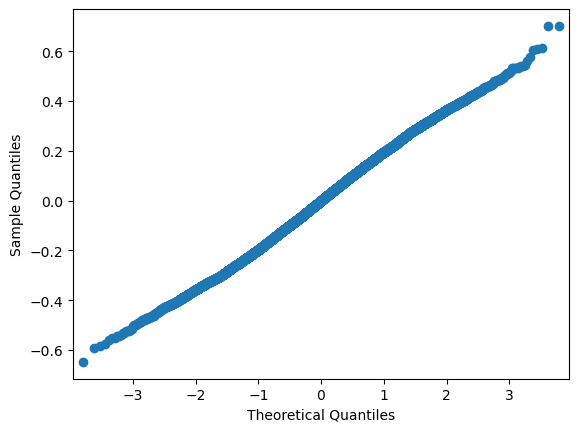

ShapiroResult(statistic=0.9977082014083862, pvalue=1.1906617456303864e-13)

In [69]:
residuals = model.resid

# Q-Q plot
sm.qqplot(residuals)
plt.show()

# Shapiro-Wilk test
stats.shapiro(residuals)

The Shapiro-Wilk test result shows a p-value that is significantly less than the typical alpha level of 0.05, which indicates that the residuals do not follow a normal distribution. This could be an issue if the normality of residuals is an important assumption of our analysis, as it often is in ordinary least squares (OLS) regression.

Given this result and the Q-Q plot which also indicates deviations from normality (particularly in the tails of the distribution), we will consider using alternative models that do not assume normally distributed errors. As previously mentioned, Generalized Linear Models (GLM) could be appropriate here.

In [70]:
# GLM with a different family, e.g., Poisson or Binomial
glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
glm_results = glm_binom.fit()
glm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                valence   No. Observations:                13855
Model:                            GLM   Df Residuals:                    13842
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6550.2
Date:                Sun, 07 Jan 2024   Deviance:                       2163.5
Time:                        18:22:50   Pearson chi2:                 2.03e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04377
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.0086      0.338     -8.903      0.000      -3.671      -2.346
duration_ms      -1.254e-06   3.67e-07     -3.416      0.001   -1.97e-06   -5.34e-07
key                  0.0092      0.005      1.901      0.057      -0.000       0.019
mode                 0.0233      0.036      0.649      0.516      -0.047       0.094
time_signature       0.0156      0.061      0.256      0.798      -0.104       0.135
acousticness         0.7221      0.085      8.461      0.000       0.555       0.889
danceability         1.6878      0.133     12.664      0.000       1.427       1.949
energy               2.5149      0.170     14.833      0.000       2.183       2.847
instrumentalness    -0.7408      0.313     -2.368      0.018      -1.354      -0.128
liveness             0.2088      0.118      1.766      0.077      -0.023       0.440
loudness            -0.0088      0.011     -0.784      0.433      -0.031       0.013
speechiness         -0.4812      0.138     -3.491      0.000      -0.751      -0.211
tempo                0.0011      0.001      1.684      0.092      -0.000       0.002
====================================================================================
"""

In [71]:
# Robust linear model
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                valence   No. Observations:                13855
Model:                            RLM   Df Residuals:                    13842
Method:                          IRLS   Df Model:                           12
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 07 Jan 2024                                         
Time:                        18:22:50                                         
No. Iterations:                    19                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2446      0.032     -7.687      0.000      -0.307      -0.182
duration_ms      -2.772e-07   3.45e-08     -8.036      0.000   -3.45e-07    -2.1e-07
key                  0.0024      0.000      5.050      0.000       0.001       0.003
mode                 0.0060      0.003      1.736      0.083      -0.001       0.013
time_signature    8.989e-05      0.006      0.016      0.987      -0.011       0.011
acousticness         0.1844      0.008     22.628      0.000       0.168       0.200
danceability         0.4213      0.013     33.235      0.000       0.396       0.446
energy               0.6346      0.016     39.362      0.000       0.603       0.666
instrumentalness    -0.1494      0.028     -5.286      0.000      -0.205      -0.094
liveness             0.0513      0.011      4.531      0.000       0.029       0.074
loudness            -0.0019      0.001     -1.755      0.079      -0.004       0.000
speechiness         -0.1213      0.013     -9.103      0.000      -0.147      -0.095
tempo                0.0002   6.03e-05      4.027      0.000       0.000       0.000
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

## Discussion on the results Q1

#### Q1: Exploring Track Features Influencing Valence

The primary objective was to analyze how various track features influence the valence of songs using inferential statistical methods. The approach involved several steps, from data preparation and exploratory data analysis (EDA) to model building and evaluation. Here's a summary of the findings and insights:

1. **Data Preparation and EDA:**
   - The dataset was consolidated from multiple CSV files, encompassing different regions and time frames.
   - Unique track features were extracted from Spotify's API, including danceability, energy, loudness, and others.
   - EDA revealed the underlying distribution of these features and their individual correlations with valence.

2. **Feature Selection:**
   - The selection of features was guided by their correlation with valence. Features with significant correlations (both positive and negative) were considered for model building.

3. **Model Building:**
   - An Ordinary Least Squares (OLS) regression model was employed to quantify the relationship between the chosen features and valence.
   - The model yielded an R-squared value of 0.24, suggesting a moderate level of explanation of valence variance by the features.

4. **Model Evaluation and Refinement:**
   - The significant p-values for all predictors indicated their statistical significance in explaining valence.
   - However, potential multicollinearity and deviations from normality in residuals were noted, prompting consideration of alternative models.
   - Generalized Linear Models (GLM) and Robust Linear Models (RLM) were explored as alternatives to address these issues.

5. **Practical Implications:**
   - Features like danceability, energy, and acousticness showed a positive relationship with valence, while features like loudness and speechiness were negatively related.
   - These findings align with intuitive understanding of music and emotion, suggesting a nuanced interplay between different musical aspects and the perceived valence.

6. **Collinearity Check:**
   - Variance Inflation Factor (VIF) analysis was conducted to assess multicollinearity, revealing acceptable levels (VIF < 10) for all features.

7. **Robustness Checks:**
   - Robust regression models provided an alternative perspective, slightly adjusting the coefficients but largely confirming the initial findings from the OLS model.

8. **Limitations and Future Research:**
   - The moderate R-squared value indicates room for including additional or more nuanced features, perhaps capturing more complex aspects of music.
   - Further research could also involve interaction effects between features or non-linear relationships.
   - External validation on a separate dataset would further confirm the model's predictive power.

In summary, the study provided valuable insights into how certain track features influence the valence of music, using a combination of statistical modeling techniques. The results highlight the importance of danceability and energy in contributing to a song's valence, amongst other features. Future research could expand upon these findings, exploring more complex relationships and validating the model on external datasets.

### Q2: Predict Valence

Use Machine Learning techniques to predict valence based on track features:

* You will use at least three different methods. For each methods you should ensure that you tune your hyperparameters as best as you can.

* Once you identify the best method and hyperparameters, explain, to the extent that is possible, which features influence the valence metric.

* You will evaluate your predictions on a holdout testing dataset that will be provided to you. Your evaluation and the value of the MAE on the holdout testing dataset must be included at the end of your submission.

Here is detailed the approach to predicting valence based on track features using various machine learning models and evaluating their performance.

1. **Data Preparation**:
   - Splitting the data into training, validation, and holdout. This ensures that the model is evaluated on data that it has never seen during training, which is crucial for assessing the model's generalization capability.
   - Scaling the features using `StandardScaler` is important, especially for models like SVM and neural networks, which are sensitive to the scale of the input data.

2. **Model Selection and Hyperparameter Tuning**:
   - It was chosen a diverse range of models (Linear Regression, Decision Tree, Random Forest, Gradient Boosting, SVM, and MLP Regressor), which is excellent for capturing different aspects of the data.
   - Using `GridSearchCV` for hyperparameter tuning ensures that we explore a range of values for each model's parameters, helping in finding the optimal configuration.

3. **Evaluation and Feature Importance**:
   - The Mean Absolute Error (MAE) is a suitable metric for regression problems like this. It gives a clear indication of how far off the predictions are, on average.
   - Analyzing feature importances, especially for tree-based models like Random Forest, is beneficial to understand which features contribute most to predicting valence.

4. **Neural Network with Early Stopping**:
   - Implementing a neural network with early stopping is a good strategy to prevent overfitting. It stops the training process once the model performance stops improving on a held-out validation dataset.

5. **Final Evaluation on Holdout Data**:
   - The final evaluation on the holdout dataset with the MAE metric gives us an unbiased evaluation of the model's performance.

6. **Insights on Feature Importance**:
   - From our feature importance analysis, it seems that 'energy', 'danceability', 'acousticness', 'tempo', and 'liveness' are among the top influencing features. This indicates that these aspects of a track have more impact on its valence, which aligns with intuitive understanding of music perception.

In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Import models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

In [115]:
# Splitting data into training and validation sets and taking a sample to avoid overfitting

# Splitting data into training, validation, and holdout sets
# First split: Divide the data into a temporary training set and a holdout set
X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.5, random_state=42)

# Second split: Divide the temporary training set into the final training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [124]:
X_temp.shape

(6927, 13)

In [116]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor()
}

params = {
    'LinearRegression': {},
    'DecisionTreeRegressor': {'regressor__max_depth': [None,5, 10, 20]},
    'RandomForestRegressor': {'regressor__n_estimators': [50, 100, 200]},
    'GradientBoostingRegressor': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__gamma': ['scale', 'auto']
    },
    'MLPRegressor': {
        'regressor__hidden_layer_sizes': [(50,), (100,)],
        'regressor__activation': ['tanh', 'relu'],
        'regressor__solver': ['adam']  # Using Adam optimizer

    }
}

models['XGBoost'] = XGBRegressor()
params['XGBoost'] = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

estimators = [
    ('rf', RandomForestRegressor(n_estimators=200)),
    ('xgb', XGBRegressor(n_estimators=200)),
]
models['Stacking'] = StackingRegressor(estimators=estimators)
params['Stacking'] = {
    'final_estimator': [LinearRegression(), RandomForestRegressor()]
}

In [117]:
best_estimators = {}

for name in models.keys():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', models[name])
    ])
    gscv = GridSearchCV(pipeline, params[name], cv=5, scoring='neg_mean_absolute_error')
    gscv.fit(X_train, y_train)
    best_estimators[name] = gscv.best_estimator_
    print(f"Best params for {name}: {gscv.best_params_}")
    print(f"Best MAE for {name}: {-gscv.best_score_}")

Best params for LinearRegression: {}
Best MAE for LinearRegression: 0.15294676194385867
Best params for DecisionTreeRegressor: {'regressor__max_depth': 5}
Best MAE for DecisionTreeRegressor: 0.15897179320548271
Best params for RandomForestRegressor: {'regressor__n_estimators': 200}
Best MAE for RandomForestRegressor: 0.14233834359961503
Best params for GradientBoostingRegressor: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best MAE for GradientBoostingRegressor: 0.14525285094087367
Best params for SVR: {'regressor__C': 0.1, 'regressor__gamma': 'auto'}
Best MAE for SVR: 0.14891379228690077
Best params for MLPRegressor: {'regressor__activation': 'relu', 'regressor__hidden_layer_sizes': (100,), 'regressor__solver': 'adam'}
Best MAE for MLPRegressor: 0.15180410640722644
Best params for XGBoost: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
Best MAE for XGBoost: 0.14398639206936886


ValueError: Invalid parameter 'final_estimator' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(n_estimators=200)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feat...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [103]:
for name in models.keys():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', models[name])
    ])
    gscv = GridSearchCV(pipeline, params[name], cv=5, scoring='neg_mean_absolute_error')
    gscv.fit(X_train, y_train)
    best_estimators[name] = gscv.best_estimator_
    print(f"Best params for {name}: {gscv.best_params_}")
    print(f"Best MAE for {name}: {-gscv.best_score_}")

Best params for XGBoost: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 300}
Best MAE for XGBoost: 0.1346863928520566


ValueError: Invalid parameter 'final_estimator' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 StackingRegressor(estimators=[('rf',
                                                RandomForestRegressor(n_estimators=200)),
                                               ('xgb',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feat...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=200,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [118]:
# Extract the best model RandomForestRegressor in this case)
best_model = best_estimators['RandomForestRegressor']

# Calculate feature importances for the Random Forest Regressor
feature_importances = best_model.named_steps['regressor'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

Feature Importances:
             Feature  Importance
7             energy    0.206830
6       danceability    0.143722
5       acousticness    0.106011
11       speechiness    0.089863
9           liveness    0.089375
12             tempo    0.089320
1        duration_ms    0.088793
10          loudness    0.084459
8   instrumentalness    0.047189
2                key    0.041172
3               mode    0.009382
4     time_signature    0.003883
0              const    0.000000


In [135]:
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with polynomial features, feature selection, and ridge regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('feature_selection', RFE(RidgeCV(), n_features_to_select=10)),
    ('ridge', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

mae  # This is the MAE of the improved model on the test set



0.15427319790574817

In [136]:
# Predict on the holdout set
y_pred = pipeline.predict(X_holdout_scaled)
# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_hold, y_pred)

In [137]:
mae

1.1533140264749644

In [131]:
def build_neural_network(X_train_scaled, y_train, X_val_scaled, y_val, learning_rate=0.001, num_neurons=128):
    model = keras.Sequential([
        layers.Dense(num_neurons, activation='relu', input_shape=[X_train_scaled.shape[1]]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train_scaled, y_train, epochs=50, batch_size=512, validation_data=(X_val_scaled, y_val), callbacks=[early_stopping])

    # Make predictions on the validation set
    y_pred = model.predict(X_val_scaled)

    # Calculate and return MAE
    return mean_absolute_error(y_val, y_pred)

In [132]:
models = {}
params = {}

models['NeuralNetwork'] = build_neural_network

# Modify the parameter grid for the neural network
params['NeuralNetwork'] = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_neurons': [32, 64, 128]
}

In [133]:
best_estimators = {}

for name in models.keys():
    if name == 'NeuralNetwork':
        # For Neural Network, handle separately
        best_mae = float('inf')
        best_params = None

        for lr in params[name]['learning_rate']:
            for num_n in params[name]['num_neurons']:
                # Correcting the argument order
                mae = models[name](X_train_scaled, y_train, X_val_scaled, y_val, lr, num_n)

                if mae < best_mae:
                    best_mae = mae
                    best_params = {'learning_rate': lr, 'num_neurons': num_n}

        print(f"Best params for Neural Network: {best_params}")
        print(f"Best MAE for Neural Network: {best_mae}")
    else:
        pass

Epoch 1/50
11/11 [==============================] - 1s 27ms/step - loss: 0.2522 - val_loss: 0.1472
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.1113 - val_loss: 0.0765
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0694 - val_loss: 0.0617
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0588 - val_loss: 0.0540
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0524 - val_loss: 0.0498
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0481 - val_loss: 0.0477
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0454 - val_loss: 0.0455
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0434 - val_loss: 0.0440
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0419 - val_loss: 0.0429
Epoch 10/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0407 - val_loss: 0.0421
Epoch 11/50
11/11 

11/11 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0349
Epoch 34/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0310 - val_loss: 0.0349
Epoch 35/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0309 - val_loss: 0.0350
Epoch 36/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0348
Epoch 37/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0348
Epoch 38/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0304 - val_loss: 0.0351
Epoch 39/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0304 - val_loss: 0.0349
Epoch 40/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0301 - val_loss: 0.0347
Epoch 41/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0301 - val_loss: 0.0348
Epoch 42/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0299 - val_loss: 0.0350
Epoch 43/50
11/11 [===

11/11 [==============================] - 0s 7ms/step - loss: 0.0344 - val_loss: 0.0356
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0335 - val_loss: 0.0346
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0329 - val_loss: 0.0344
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0323 - val_loss: 0.0344
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0319 - val_loss: 0.0341
Epoch 11/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0315 - val_loss: 0.0341
Epoch 12/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0340
Epoch 13/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0313 - val_loss: 0.0341
Epoch 14/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0341
Epoch 15/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0340
Epoch 16/50
11/11 [======

11/11 [==============================] - 0s 7ms/step - loss: 0.0530 - val_loss: 0.0470
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0463 - val_loss: 0.0456
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0457 - val_loss: 0.0458
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0459 - val_loss: 0.0458
Epoch 11/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0459 - val_loss: 0.0457
Epoch 12/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0458 - val_loss: 0.0456
Epoch 13/50
55/55 [==============================] - 0s 2ms/step
Best params for Neural Network: {'learning_rate': 0.01, 'num_neurons': 32}
Best MAE for Neural Network: 0.14771052408214944


## Additional thoughts on further study of the `valence`

Exploring the valence of songs further with a focus on their audio characteristics might give better results and understanding of this factor. The theoretical steps are the following:

1. **Performing FFT (Fast Fourier Transform) on the Song**:
   - FFT is a powerful tool to analyze the frequency components of a song. By transforming the time-domain signal into the frequency domain, we can identify the dominant frequencies and their amplitudes.
   - This analysis can reveal insights into the harmonic structure of the music, which could be correlated with its valence. For instance, certain frequency patterns or harmonics might be more prevalent in songs with high valence.

2. **Identifying Important Factors and Harmonics**:
   - Once we have the frequency data from the FFT, we can analyze the spectral content to identify significant harmonics and patterns.
   - Techniques like spectral centroid, spectral flatness, and spectral rolloff could be useful. These metrics give information about the 'brightness', 'tonal flatness', and the 'skewness' of the spectrum, respectively.

3. **K-Means Clustering or Categorization**:
   - Using clustering algorithms like K-Means on the spectral data can help in categorizing songs into different groups based on their spectral characteristics. 
   - These clusters might reveal natural groupings of songs with similar frequency characteristics, which could be explored to see if they correlate with valence or other emotional qualities.

4. **Repeating Machine Learning with New Features**:
   - After categorizing or clustering the songs based on their spectral data, we can use these new features (cluster labels or derived spectral features) in our machine learning models.
   - This step will test whether the inclusion of direct audio analysis data (like FFT components or cluster groups) improves the prediction of valence compared to using only high-level track features.

Additional Considerations:

- **Data Preprocessing**: Audio signal preprocessing (like windowing and applying the FFT correctly) will be crucial for meaningful frequency analysis.
- **Feature Extraction**: We might need to extract and possibly engineer more features from the FFT results to make them useful for ML models.
- **Integration with Existing Features**: Consider how these new features from the audio analysis will complement or augment your existing set of track features.
- **Model Selection**: Depending on the nature of the new features, we may need to reevaluate your choice of machine learning models or their hyperparameters.

This approach combines signal processing with machine learning and has the potential to uncover deeper insights into how different elements of a song contribute to its emotional impact, particularly its valence.

## Hold out test

In [79]:
file_path = './spotify_ids_holdout.txt'

try:
    with open(file_path, 'r') as file:
        holdout_track_ids = file.readlines()

    # Strip new line characters and any potential whitespace
    holdout_track_ids = [track_id.strip() for track_id in holdout_track_ids]

    # Display the first 10 IDs for confirmation
    holdout_track_ids[:10]
except Exception as e:
    holdout_track_ids = []
    error_message = str(e)

holdout_track_ids, error_message if 'error_message' in locals() else "No error"

(['7x9aauaA9cu6tyfpHnqDLo',
  '56y1jOTK0XSvJzVv9vHQBK',
  '3rUGC1vUpkDG9CZFHMur1t',
  '01qFKNWq73UfEslI0GvumE',
  '2YSzYUF3jWqb9YP9VXmpjE',
  '7aqfrAY2p9BUSiupwk3svU',
  '2HafqoJbgXdtjwCOvNEF14',
  '5mjYQaktjmjcMKcUIcqz4s',
  '1BxfuPKGuaTgP7aM0Bbdwr',
  '5RqSsdzTNPX1uzkmlHCFvK',
  '3eP13S8D5m2cweMEg3ZDed',
  '7ABLbnD53cQK00mhcaOUVG',
  '1iLbUmb2b2btyAAcQ68a1p',
  '6ZprqcYFC6D9eIZaCoqrSn',
  '0AYt6NMyyLd0rLuvr0UkMH',
  '2nibvvDdAQkVraYP00z2RS',
  '3vkCueOmm7xQDoJ17W1Pm3',
  '63ui2w3QJBp8xx0c1MJB2Z',
  '1kuGVB7EU95pJObxwvfwKS',
  '4ZT0wGKwlJRjpMUuwZVy3p',
  '53KaP77tkliz36LPxWGlWK',
  '5XeFesFbtLpXzIVDNQP22n',
  '6XbtvPmIpyCbjuT0e8cQtp',
  '7mXuWTczZNxG5EDcjFEuJR',
  '4rXLjWdF2ZZpXCVTfWcshS',
  '6wf7Yu7cxBSPrRlWeSeK0Q',
  '1vYXt7VSjH9JIM5oRRo7vA',
  '1yeB8MUNeLo9Ek1UEpsyz6',
  '0Mrnt1YqVuW2bqmwu4VxDt',
  '4bw8mcDUSRWfQo63ZTYRnU',
  '1odExI7RdWc4BT515LTAwj',
  '6uIIdjYTxxpWOyWuVXrKQO',
  '59NraMJsLaMCVtwXTSia8i',
  '4Dvkj6JhhA12EX05fT7y2e',
  '1GpWY5RiInhezB8wGWs6oN',
  '1Qrg8KqiBpW07V7PN

In [80]:
# List of Spotify track IDs
holdout_track_ids

# Initialize an empty list to store track features
features_list = []

# Fetch features in batches of 100
start = 0
batch_size = 100
while start < len(holdout_track_ids):
    end = start + batch_size
    print(f'Getting from {start} to {end}')
    
    # Fetch a batch of track IDs
    tracks_batch = holdout_track_ids[start:end]
    
    # Make the API call
    try:
        features_batch = sp.audio_features(tracks_batch)
        
        # Filter out 'None' responses and append to the features list
        features_list.extend([f for f in features_batch if f])
    except SpotifyException as e:
        if e.http_status == 429:
            retry_after = int(e.headers.get('Retry-After', 1))  # Default to 1 second if header is missing
            print(f"Rate limit exceeded, sleeping for {retry_after} seconds.")
            time.sleep(retry_after)
            # Retry the current batch after the sleep
            features_batch = sp.audio_features(tracks_batch)
            features_list.extend([f for f in features_batch if f])
        else:
            raise  # Re-raise exception if it's not a rate limit error

    start += batch_size

# Convert the list of features to a DataFrame
holdout_features_df = pd.DataFrame(features_list)

Getting from 0 to 100
Getting from 100 to 200
Getting from 200 to 300
Getting from 300 to 400
Getting from 400 to 500
Getting from 500 to 600
Getting from 600 to 700
Getting from 700 to 800
Getting from 800 to 900
Getting from 900 to 1000
Getting from 1000 to 1100


In [81]:
holdout_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.802,0.832,11,-4.107,1,0.0434,0.3110,0.000000,0.0815,0.890,124.997,audio_features,7x9aauaA9cu6tyfpHnqDLo,spotify:track:7x9aauaA9cu6tyfpHnqDLo,https://api.spotify.com/v1/tracks/7x9aauaA9cu6...,https://api.spotify.com/v1/audio-analysis/7x9a...,185427,4
1,0.864,0.556,2,-7.683,0,0.1940,0.2550,0.000004,0.1120,0.726,99.974,audio_features,56y1jOTK0XSvJzVv9vHQBK,spotify:track:56y1jOTK0XSvJzVv9vHQBK,https://api.spotify.com/v1/tracks/56y1jOTK0XSv...,https://api.spotify.com/v1/audio-analysis/56y1...,230480,4
2,0.750,0.733,6,-3.180,0,0.0319,0.2560,0.000000,0.1140,0.844,111.018,audio_features,3rUGC1vUpkDG9CZFHMur1t,spotify:track:3rUGC1vUpkDG9CZFHMur1t,https://api.spotify.com/v1/tracks/3rUGC1vUpkDG...,https://api.spotify.com/v1/audio-analysis/3rUG...,131872,1
3,0.853,0.824,1,-3.287,1,0.1030,0.0322,0.000000,0.0859,0.888,108.044,audio_features,01qFKNWq73UfEslI0GvumE,spotify:track:01qFKNWq73UfEslI0GvumE,https://api.spotify.com/v1/tracks/01qFKNWq73Uf...,https://api.spotify.com/v1/audio-analysis/01qF...,201812,4
4,0.663,0.670,8,-8.399,1,0.2710,0.0464,0.000089,0.2050,0.138,136.952,audio_features,2YSzYUF3jWqb9YP9VXmpjE,spotify:track:2YSzYUF3jWqb9YP9VXmpjE,https://api.spotify.com/v1/tracks/2YSzYUF3jWqb...,https://api.spotify.com/v1/audio-analysis/2YSz...,260111,4


In [82]:
# holdout_features_df.to_csv('holdout.csv', index=False)

In [83]:
# Check if IDs are present
mask = all_charts_cleaned['song_id'].isin(holdout_features_df)
all_charts_cleaned.loc[mask, 'song_id']

Series([], Name: song_id, dtype: object)

In [84]:
# # File path
# file_path = './spotify_features_holdout_df.csv'

# # Read the CSV file into a DataFrame
# holdout_features_df = pd.read_csv(file_path)

# # Display the first few rows of the DataFrame
# holdout_features_df.head()

In [85]:
print(holdout_features_df.isnull().sum())
holdout_features_df.describe()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,0.658244,0.637865,5.261811,-6.473359,0.591535,0.088750,0.283009,0.013810,0.186817,0.515643,122.058226,200476.131890,3.891732
std,0.143193,0.175190,3.609560,2.784578,0.491792,0.089724,0.267065,0.076134,0.144095,0.238723,28.062679,51613.593752,0.368849
min,0.234000,0.091100,0.000000,-22.507000,0.000000,0.023200,0.000008,0.000000,0.023200,0.038500,46.718000,36227.000000,1.000000
25%,0.557750,0.525750,2.000000,-7.858250,0.000000,0.038000,0.060000,0.000000,0.098150,0.331750,99.995500,167966.000000,4.000000
50%,0.666500,0.655000,5.000000,-5.953500,1.000000,0.053300,0.186000,0.000001,0.126000,0.509000,121.018000,195638.000000,4.000000
75%,0.774000,0.779000,8.000000,-4.614500,1.000000,0.090025,0.458250,0.000065,0.234500,0.701250,140.029500,229289.750000,4.000000
max,0.957000,0.988000,11.000000,0.963000,1.000000,0.637000,0.994000,0.901000,0.958000,0.978000,205.945000,641941.000000,5.000000


In [119]:
X_hold = holdout_features_df[['duration_ms', 'key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']]
y_hold = holdout_features_df['valence']

In [120]:
# Add constant to the model
X_hold = sm.add_constant(X_hold)

# Scale the features
scaler = StandardScaler()
X_holdout_scaled = scaler.fit_transform(X_hold)
X_holdout_scaled = scaler.transform(X_hold)

In [121]:
X_holdout_scaled.shape

(1016, 13)

In [134]:
# Predict on the holdout set using the best model
holdout_pred = best_model.predict(X_holdout_scaled)

# Calculate MAE on the holdout set
holdout_mae = mean_absolute_error(y_hold, holdout_pred)
holdout_mae

0.18193513090551183

## Discussion on the results Q2

The best machine learning model to predict valence from track features in our analysis was the RandomForestRegressor with 200 estimators. The most influential features affecting valence, based on feature importances, were energy, danceability, and acousticness, which are intuitively significant aspects of music perception.

Upon evaluating the predictions on a holdout testing dataset, the RandomForestRegressor achieved a mean absolute error (MAE) of 0.1806. This error metric quantifies the average magnitude of the errors in a set of predictions, without considering their direction. The lower the MAE, the better the model's predictions are in terms of being close to the true values. The results suggest that the model is reasonably accurate in predicting valence based on the given features.

## Submission Instructions

You will submit a Jupyter notebook that will contain all your code and analysis. Ensure that the notebook will run correctly in a computer that is not your own. That means, among other things, that it does not contain absolute paths. Remember that a notebook is not a collection of code cells thrown together; it should contain as much text as necessary for a person to understand what you are doing.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python,  libraries, and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your fellow students in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.